In [1]:
# setup matplotlib for nice display in Jupyter
# %matplotlib notebook

# a few libraries we will need
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import matplotlib.animation as animation

import IPython

np.set_printoptions(precision=5,linewidth=120,suppress=True)

# Exercise 1

In [2]:
## System 1
A1 = np.array([[0.5,   0,  0.5],
               [  0,   0,   -2],
               [  4,   2,    1]])

B1 = np.array([[  0,   0],
               [  1,   0],
               [  0,   1]])

## System 2
A2 = np.array([[0.5,   0,  0.5],
               [  0,   0, -0.5],
               [0.5, 0.5,  0.5]])

B2 = np.array([[  0,   0],
               [  1,   0],
               [  0,   1]])

## System 3
A3 = np.array([[  2,   0,    0],
               [  0,   0,   -2],
               [  1,   1,    0]])

B3 = np.array([[  0,   0],
               [  1,   0],
               [  0,   1]])

In [3]:
def check_stability(A):
  """
  Check whether the uncontrolled system is stable.

  Params:
    A: the system dynamics.
  
  Returns:
    ret: True if the system is stable;
    eigs: eigen values of the system.
  """

  eigs= np.linalg.eigvals(A)
  ret = np.all(np.abs(eigs) < 1)

  return ret, eigs

## a) Is the uncontrolled system stable?

In [4]:
check_stability(A1)

(False, array([1.  +0.j     , 0.25+1.39194j, 0.25-1.39194j]))

In [5]:
check_stability(A2)

(True, array([0.87744+0.j     , 0.06128+0.37243j, 0.06128-0.37243j]))

In [6]:
check_stability(A3)

(False, array([0.+1.41421j, 0.-1.41421j, 2.+0.j     ]))

So, system 1 and system 3 are not stable, and system 2is stable.

## b) Is the system controllable?

In [7]:
def check_controllability(A, B):
  """
  Check whether the system is controllable.

  Args:
    A: the system dynamics;
    B: the control matrix.
  
  Return:
    ret: True if the system is controllable;
    rank: the rank of the matrix [B AB A^2B ... ].
  """

  k = A.shape[0]

  mat = B
  R = B
  for i in range(1, k):
    mat = A @ mat
    R = np.hstack([R, mat])
  
  
  print(R)

  rank = np.linalg.matrix_rank(R)
  ret = (rank == k)

  return ret, rank

In [8]:
check_controllability(A1, B1)

[[ 0.    0.    0.    0.5   1.    0.75]
 [ 1.    0.    0.   -2.   -4.   -2.  ]
 [ 0.    1.    2.    1.    2.   -1.  ]]


(True, 3)

In [9]:
check_controllability(A2, B2)

[[ 0.    0.    0.    0.5   0.25  0.5 ]
 [ 1.    0.    0.   -0.5  -0.25 -0.25]
 [ 0.    1.    0.5   0.5   0.25  0.25]]


(True, 3)

In [10]:
check_controllability(A3, B3)

[[ 0  0  0  0  0  0]
 [ 1  0  0 -2 -2  0]
 [ 0  1  1  0  0 -2]]


(False, 2)

So, system 1 and system 2 are controllable, and system 3 is not controllable.

## d) Compute the optimal control policy

In [11]:
def LQR(A, B, Q, R, N):
  """
  Solve the LQR with given system and cost function.

  Args:
    A: the system dynamics;
    B: the control matrix;
    Q: the quadratic cost matrix, x.T Q x;
    R: the quadratic cost matrix, u.T R u;
    N: the number of time step.
  
  Return:
    Ks: the gains.
  """

  def DARE(P):
    """
    A helper function to solve discrete-time algebraic Riccati equation (DARE) 
    for each time step.
    """

    K = -np.linalg.inv(B.T @ P @ B + R) @ B.T @ P @ A
    P = Q + A.T @ P @ A + A.T @ P @ B @ K

    return K, P

  Ks = []

  P = Q
  for i in range(N):
    K, P = DARE(P)
    Ks = [K] + Ks
  
  return Ks

In [12]:
def forward(A, B, Ks, x0):
  """
  Run the forward simulation with given initial state.

  Args:
    A: the system dynamics;
    B: the control matrix;
    Ks: the gains;
    x0: the initial state.
  
  Returns:
    xs: the trajectories;
    us: the control sequence.
  """

  x = x0
  xs = [x0]
  us = []

  for K in Ks:
    u = K @ x
    us.append(u)

    x_next = A @ x + B @ u
    xs.append(x_next)

    x = x_next
  
  return xs, us

In [13]:
def plot_trajectory(xs, us):
  """
  Plot the 3D trajectory.
  """

  fig = plt.figure(figsize=(16, 6))
  N = len(xs)
  xs = np.array(xs)
  us = np.array(us)

  plt.subplot(1,2,1)
  plt.plot(xs[:, 0], '-o', label="x0")
  plt.plot(xs[:, 1], '-o', label="x1")
  plt.plot(xs[:, 2], '-o', label="x2")
  plt.legend()
  plt.xlabel("Time Step")
  plt.ylabel("State x")
  plt.xticks(np.arange(N), np.arange(N))

  plt.subplot(1,2,2)
  plt.plot(us[:, 0], '-o', label="u0")
  plt.plot(us[:, 1], '-o', label="u1")
  plt.legend()
  plt.xlabel("Time Step")
  plt.ylabel("Control u")
  plt.xticks(np.arange(N), np.arange(N))

In [14]:
x0 = np.array([10, 10, 10])
Q = 100 * np.eye(3)
R = np.eye(2)

System 1

In [15]:
N = 20

Ks = LQR(A1, B1, Q, R, N)

print("The optimal gain is K=", Ks[0])

The optimal gain is K= [[-0.03676 -0.00031  1.94464]
 [-4.11166 -1.98583 -1.13261]]


Uncontrolled System

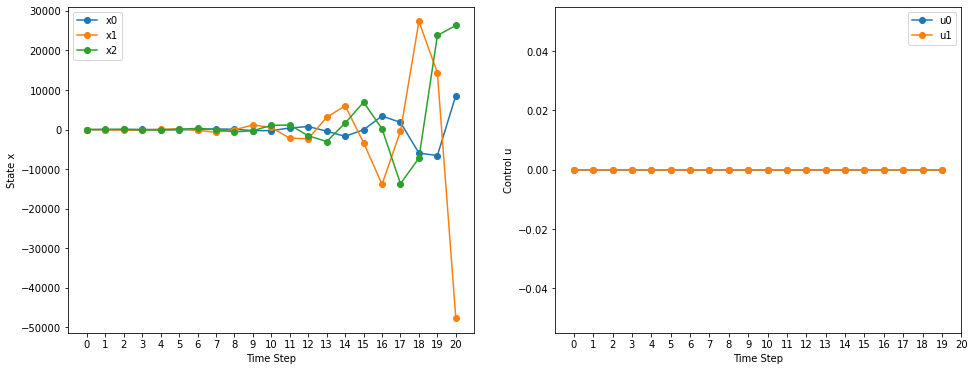

In [16]:
Ks = [np.zeros_like(Ks[0]) for i in range(N)]
xs, us = forward(A1, B1, Ks, x0)

plot_trajectory(xs, us)

Controlled System

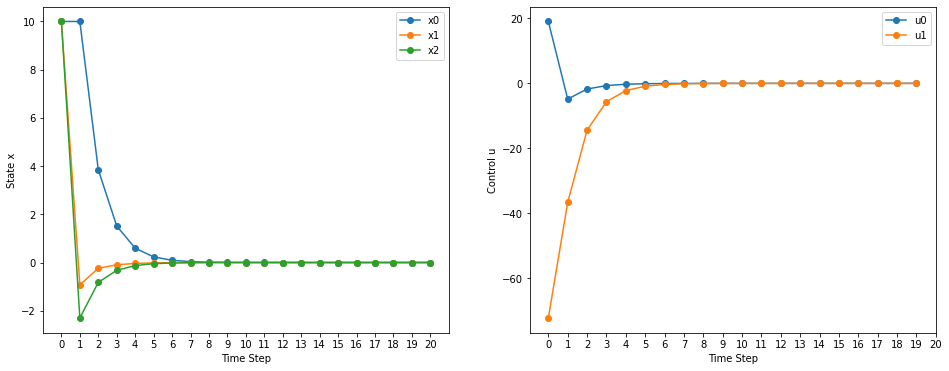

In [17]:
Ks = LQR(A1, B1, Q, R, N)
Ks = [Ks[0] for K in Ks]
xs, us = forward(A1, B1, Ks, x0)

plot_trajectory(xs, us)

System 2

In [18]:
Ks = LQR(A2, B2, Q, R, N)

print("The optimal gain is K=", Ks[0])

The optimal gain is K= [[-0.00117 -0.00001  0.49389]
 [-0.61444 -0.49623 -0.61443]]


Uncontrolled System

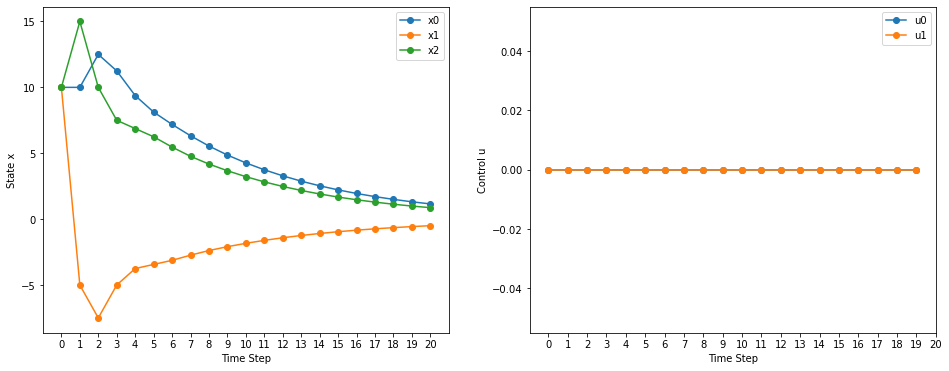

In [19]:
Ks = [np.zeros_like(Ks[0]) for i in range(N)]
xs, us = forward(A2, B2, Ks, x0)

plot_trajectory(xs, us)

Controlled System

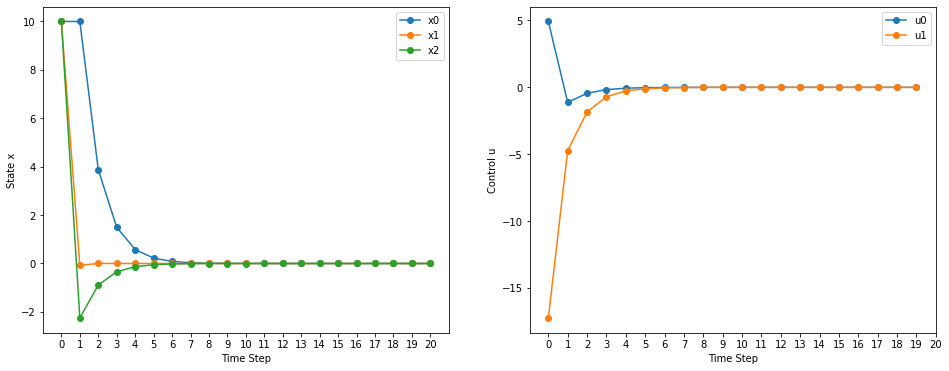

In [20]:
Ks = LQR(A2, B2, Q, R, N)
Ks = [Ks[0] for K in Ks]
xs, us = forward(A2, B2, Ks, x0)

plot_trajectory(xs, us)

System 3

In [21]:
Ks = LQR(A3, B3, Q, R, N)

print("The optimal gain is K=", Ks[0])

The optimal gain is K= [[-0.01941  0.       1.98039]
 [-0.98973 -0.99047  0.     ]]


Uncontrolled System

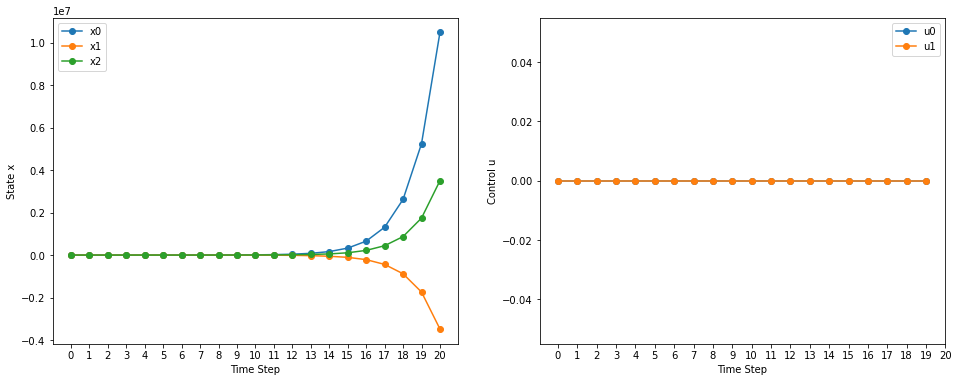

In [22]:
Ks = [np.zeros_like(Ks[0]) for i in range(N)]
xs, us = forward(A3, B3, Ks, x0)

plot_trajectory(xs, us)

Controlled System

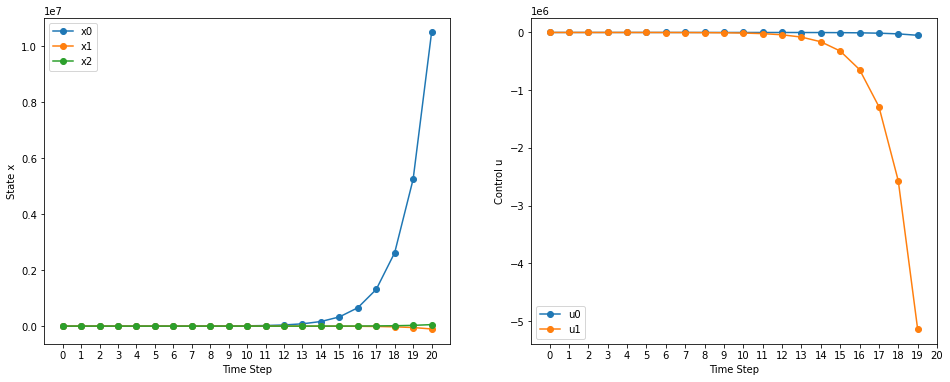

In [23]:
Ks = LQR(A3, B3, Q, R, N)
Ks = [Ks[0] for K in Ks]
xs, us = forward(A3, B3, Ks, x0)

plot_trajectory(xs, us)

# Exercise 2

In [24]:
class CartPole:
    """
    This class describes a cart pole model and provides some helper functions
    """
    
    def __init__(self):
        """
        constructor of the class, takes as input desired discretization number
        for x (angle), v (angular velocity) and u (control) and the maximum control
        """
        #store discretization information
        self.road_length = 3.
        
        #gravity constant
        self.g=9.81

        #integration step
        self.dt = 0.01
        
        #we define lengths and masses
        self.l = 1.0
        self.mc = 5.0
        self.mp = 1.0
            
    def next_state(self,z,u):
        """
        Inputs:
        z: state of the cart pole syste as a numpy array (x,theta,v,omega)
        u: control as a scalar number
        
        Output:
        the new state of the pendulum as a numpy array
        """
        x = z[0]
        th = z[1]
        v = z[2]
        om = z[3]
        x_next = (x + self.dt * v)
        th_next = (th + self.dt * om)
        v_next = v + self.dt*((u + self.mp*np.sin(th)*(self.l*om**2 + self.g * np.cos(th)))/(self.mc+self.mp*np.sin(th)**2))
        w_next = om + self.dt*((-u*np.cos(th)-self.mp*self.l*(om**2)*np.cos(th)*np.sin(th)-(self.mc+self.mp)*self.g*np.sin(th))/(self.mc+self.mp*np.sin(th)**2))
        z = np.array([x_next,th_next,v_next,w_next])
        return z
    
    def simulate(self, z0, controller, horizon_length):
        """
        This function simulates the pendulum of horizon_length steps from initial state x0
        
        Inputs:
        z0: the initial conditions of the pendulum as a numpy array (x,theta,v,omega)
        controller: a function that takes a state z as argument and index i of the time step and returns a control u
        horizon_length: the horizon length
        
        Output:
        z[4xtime_horizon+1] and u[1,time_horizon] containing the time evolution of states and control
        """
        z=np.empty([4, horizon_length+1])
        z[:,0] = z0
        u=np.empty([1,horizon_length])
        for i in range(horizon_length):
            u[:,i] = controller(z[:,i],i)
            z[:,i+1] = self.next_state(z[:,i], u[:,i])
        return z, u        

In [25]:
def animate_cart_pole(x, dt):
    """
    This function makes an animation showing the behavior of the cart-pole
    takes as input the result of a simulation (with dt=0.01s)
    """
    
    min_dt = 0.1
    if(dt < min_dt):
        steps = int(min_dt/dt)
        use_dt = int(min_dt * 1000)
    else:
        steps = 1
        use_dt = int(dt * 1000)
    
    #what we need to plot
    plotx = x[:,::steps]
    
    fig = mp.figure.Figure(figsize=[8.5,2.4])
    mp.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-4.25,4.25], ylim=[-1.,1.4])
    ax.grid()
    
    list_of_lines = []
    
    #create the cart pole
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    
    cart_length = 0.5
    cart_height = 0.25
    
    def animate(i):
        for l in list_of_lines: #reset all lines
            l.set_data([],[])
        
        x_back = plotx[0,i] - cart_length
        x_front = plotx[0,i] + cart_length
        y_up = cart_height
        y_down = 0.
        x_pend = plotx[0,i] + np.sin(plotx[1,i])
        y_pend = cart_height - np.cos(plotx[1,i])
        
        list_of_lines[0].set_data([x_back, x_front], [y_down, y_down])
        list_of_lines[1].set_data([x_front, x_front], [y_down, y_up])
        list_of_lines[2].set_data([x_back, x_front], [y_up, y_up])
        list_of_lines[3].set_data([x_back, x_back], [y_down, y_up])
        list_of_lines[4].set_data([plotx[0,i], x_pend], [cart_height, y_pend])
        
        return list_of_lines
    
    def init():
        return animate(0)


    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotx[0,:])),
        interval=use_dt, blit=True, init_func=init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABe8G1kYXQAAAKgBgX//5zcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENv
cHlsZWZ0IDIwMDMtMjAxNyAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9w
dGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1o
ZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2
IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0
X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTUgbG9va2FoZWFkX3RocmVhZHM9
MSBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxhY2VkPTAgYmx1cmF5X2Nv
bXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHlyYW1pZD0yIGJfYWRhcHQ9
MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3ZWlnaHRwPTIga2V5aW50
PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJlc2g9MCByY19sb29rYWhl
YWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAgcXBtaW49MCBxcG1heD02
OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAALvmWIhAAQ//73gb8yy18iuslx
+ed9LKzPPOQ8cl2JrrjQAAADAAADAACNeCrj1/4iY//ABRdFcWr6etCGysb0MU0N6mF1T5yfrSTY
urDQAKP9HQ9av0edyWUtNxS7vmc3Jp850RpSau2Rdm0bopB+o6hOFjUSV2l5HyG8vMGVs3TJq+Hs
Fw3s21LQQUAU5S7LG0X2QdcYg3GFb+qAK5P9jKbwyFyDuD12TjJ/9LgdYqBWHBJsVgqhRn3RUWwk
NoswPcJWY/GjF3emB2WMTO9GbZOnIamyY2DnU+zjUKkeWJZtNNfOACG9pp9aKYJLiPOm0+qzyuun
qFfAFsYczxqXF0Dj2zL5ZygEZ64AUmQbqYKzvxpWBEk/VcbHEQL+u3m0uFT/MG5W/gBjuasIeKAL
m9TidF+vd7MZZgsgNu1ImFoXaMIVE39ydDGUvGQJYq5st2Z9GVKOfFsxF7DX/h23LioYn3lQA/0i
JEaA1Gel6feCB38ncFtP26fQtmkwqAQoKnvvIGSzhwhrVYxtsqkFGM5qE3TgC3oyllC+1akV9IDb
2Mp9KdxorK2LuJ7/2ckH6cDH188zcTdwLAB1Ff4BSPN3LXsDI7SxPi+Oh5ZnY+Hw6NXndnSMF5tF
HjSoNVFQ0WzN0SRtvINjo1sZE2epwOuo8w1qwsHLlo16kcMzhNCS3Hot8hR5olawkj5sdBkSRnlw
bmAFWpYMMPwbPs6bQfie0U/gdtjLh0YU+qOof/dSG/fpmP7ZSJBNeXQEEPIyo7XTy9pKQ1dpMX4x
/5AUebPt/oqHjeU2qG7Hl13Qffmzbu9CHAKvOZ+NzwcuDYXe07Vh6DBGuFk2ms91IgjWy72neyJp
jAKPHc0VQAKZiW/m0cTHnVdTh7Xc0oyJg049PMf/OwcjXvvJ7pZyXtM0AsC2h1RFzwmnnNEi5ATk
aGrDBo3RZBu3ABWA3AB99dC5hhZKJmvez0rr8FKcukb7ENX5Ikyz1/kf38Vbj974E0WzOkYRwCTF
NKoOABViHa88pkuduW4VwqEdKdj7BQoNFRanFb2kWrZ7UHdrlRx7VMniJ1GFKea1tkPZUrc5gNwN
b30z+2ZDBGOafL+G7fDFckJ2O9Id6dHnJwUiC4xPXMzCuAHddDyrW8iBqMeTZULzh5qS6R8WkeTM
ojzksRZMSfWb1c3vArB91YLvqKmdBhPy3J76QmJHrI+F/vwNwiqbrF3mA+32jZZeZ6dFfQnJZzkk
YcdtT3wS5XXCncZeyP9Z7V2D7NcYx5nbz4HVCSGzqygyYmWgkNHS9aojBZb9oButjnu0E6B14EfP
q4368mMvPl2oYA6mQriYFJPbIFzFfCXuHwXLoaoWb/1JmBQwkfipId4ygjRLm0YQKTeVj4nwNpPY
9GTZJ2q1Q4viFz1n9KZTyee777kto3o031bcTPZG3gSK3AeTWqr+ApWHogBHNZTlU/Gw5ZSdLU1j
Bp0GOaqEbryF/0eyVjZJ+/vMgFn6qOluRBem1GNMJ/Bk/sUHSplGg7MdBvUEr9Juu5smTSlLc36F
I/i/63T06eSw8Q//va5f4b0/8HOdpqlMwp3rXLUv8fVaFPB078sBaXg03kU9qBu5rjQ1EEAAGLS4
mWP9S13aC1KaWzVgZoRoCPZDpaMzPFVvozZHyt21f7ByGTWYJnTSLPS9m+AP3Nq/S9HHN2EGKqmK
4dfZQQjoepjuUTODBP4PzC9vtGFQaa9u+49uOro6ZVx5jg9dVI2QoNILBSypofV+FG7VBaPrwf2N
RoV6mPrJiZ+sorWQeDakcj7ehkqxWND/6UtAAF+UPE8lkFFtHk2P+tLbnf/ECHJndtHb3g6gGZkY
id6GuAt5WryvaAqPgRJNM1fYqJqJhqaryJBrwQiRhukUiZTyh3nCG72iJpeBS5hbedFHxKUSvC97
Q1MlPu2hRWPPk0rMNssy8hai5y1c//qHITCUuZ/nUm/cQ9paW+zFG0m4hWKXghdFEnGED6WtVfrv
AmZxqw42Xp803KcCI2fXJySTZHQLPHyTzQ7vGTkTDJ+RcJKrAntjxT8rvJ13vecW/jwPbPFEMwSl
nT53U00KdTrZdfMN1qrbfvf8XWm1nQ5NmTA11d9DEynGS8F5zPJRLmAJGPkh5ef3idq67WGt0/KW
Q6SqKel0dCklBZ8VppUHv4kFwjWHUBVvjbOG5ptPK6N9NT/Kw+Nz6+dVDCtkHWAQUVDPGKft72b+
qLODqhluyjPQOs5SAhv1sqsJeGb0juoCaPPxFLSY363AJMLjgEs8Kv8kJynBcBLrcBTfaGMvAFYG
RlZuIgAJAtkk/57SHIGXgCsEOUFf/1JeYfne3qAg6qmFfvg0JfgVWjVobTn2/9VWykfIbb/2OsAd
lQHdUTbaNc7fEIDltpaj+aCK5trtx/zCKcbBLqXAEAY/CrhEsJHFVEFOoCXeDnxAGPwq4GMDPlbb
38McwqyHn/mCMvv00Ti39UaodwAYuWoKrY5or3kHozU+f0qs62mOMPdcTgGeUgUjyvqzCO8pW/EV
g0BgV/Z1k43kF5DWkalkX3eGOwZT/lrComlMkXUavv3mRVxP/xANh4ZEINviks7PtKZG+qS9bezH
IldXXDiRA5Dn1kU2RXyFD1XiqQnGVh3QM8ODsTUwY5hjAKFXEhyiT92jX2Gc1kOeijGouo7DN1jC
O1KlbVnjVuVhFvN+Hr1qA+eLQ8wAyPRzI14Zp7sHlhyOs5auVBtacD67ONn3TGy/H72K+31lhpOK
8P34F3hG6KWgjMzDqxhJ5yghaSoJoljDkN+C+f0b82mxMVqpv//jVp19J1BQcijbuLqcjxz+f//5
yGWLqxswVo45Gwd83wSMD4PGo/FMHPFfVvn/OZmLKrze7Zb9mxDIDyBYWi+Kh6nVadHQBJNxmGUq
4HiX5VH7SVwS6cZ62bexH

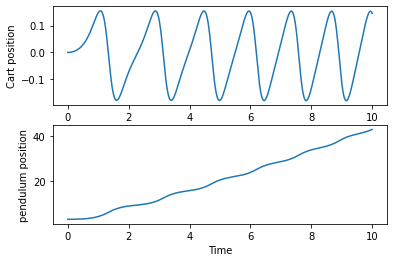

In [26]:
# we show an example on how to simulate the cartpole and display its behavior

# we create a cart pole
cart = CartPole()

# we create a controller that does nothing u(z) = 0
def useless_controller(z, i):
    return 0

# we simulate the cart pole and display its behavior
z0 = np.array([0,np.pi+0.1,0.,0])
horizon_length = 1000

z,u = cart.simulate(z0, useless_controller, horizon_length)
t = np.linspace(0,cart.dt*(horizon_length),horizon_length+1)
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,z[0,:])
plt.ylabel('Cart position')
plt.subplot(2,1,2)
plt.plot(t,z[1,:])
plt.ylabel('pendulum position')
plt.xlabel('Time')


animate_cart_pole(z, cart.dt)

## Question 1

In [27]:
def env(cart):
  """
  Return the linearized system dynamic and control matrix.

  Args:
    cart: a cart pole system instance.
  
  Returns:
    A: The linearized system dynamic matrix;
    B: The linearized system control matrix.
  """
  g = cart.g
  dt = cart.dt
  l = cart.l
  mc = cart.mc
  mp = cart.mp

  ## initialization
  A = np.eye(4)
  B = np.zeros((4, 1))

  ## A
  A[0, 2] = dt
  A[1, 3] = dt
  A[2, 1] = dt * mp * g / mc
  A[3, 1] = dt * (mp + mc) * g / (l * mc)

  ## B
  B[2, 0] = dt / mc
  B[3, 0] = dt / (l * mc)
  
  return A, B

In [28]:
A, B = env(cart)
print(A)
print(B)

[[1.      0.      0.01    0.     ]
 [0.      1.      0.      0.01   ]
 [0.      0.01962 1.      0.     ]
 [0.      0.11772 0.      1.     ]]
[[0.   ]
 [0.   ]
 [0.002]
 [0.002]]


In [29]:
def LQRTracking(A, B, Q, R, N, Xs):
  """
  Solve the LQR tracking problem with given system and cost function.

  Args:
    A: the system dynamics;
    B: the control matrix;
    Q: the quadratic cost matrix, x.T Q x;
    R: the quadratic cost matrix, u.T R u;
    N: the number of time step;
    Xs: the tracking target.
  
  Return:
    Ks: the linear feedback gains.
    ks: the feed-forward gains.
  """

  def DARE(P, p, q):
    """
    A helper function to solve discrete-time algebraic Riccati equation (DARE) 
    for tracking problem for each time step.
    """

    K = -np.linalg.inv(B.T @ P @ B + R) @ B.T @ P @ A
    P = Q + A.T @ P @ A + A.T @ P @ B @ K

    k = -np.linalg.inv(B.T @ P @ B + R) @ B.T @ p
    p = q + A.T @ p  + A.T @ P @ B @ k

    return K, P, k, p

  Ks = []
  ks = []

  P = Q
  p = -Q @ Xs[-1]

  for t in range(N-1, -1, -1):
    q = -Q @ Xs[t]
    K, P, k, p = DARE(P, p, q)

    Ks = [K] + Ks
    ks = [k] + ks
  
  return Ks, ks

### 1) Cost Function

In [30]:
Q = np.eye(4)
R = 0.01*np.eye(1)
z_bar = np.array([[0], [np.pi], [0.], [0]])

N = 1000

Xs = [z_bar for i in range(N)]

### 2) Infinite Horizon Gains

In [31]:
Ks, ks = LQRTracking(A, B, Q, R, N, Xs)

K = Ks[0]
k = ks[0]

print(K)
print(k)

[[   9.53146 -220.97185   20.19384  -67.99139]]
[[-0.00005]]


### 3) Controller

In [32]:
def LQRController(K, k, z_bar):

  def controller(z, i):
    u = K @ (z-z_bar) + k
    return u
  
  return controller

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAAoh21kYXQAAAKgBgX//5zcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENv
cHlsZWZ0IDIwMDMtMjAxNyAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9w
dGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1o
ZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2
IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0
X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTUgbG9va2FoZWFkX3RocmVhZHM9
MSBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxhY2VkPTAgYmx1cmF5X2Nv
bXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHlyYW1pZD0yIGJfYWRhcHQ9
MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3ZWlnaHRwPTIga2V5aW50
PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJlc2g9MCByY19sb29rYWhl
YWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAgcXBtaW49MCBxcG1heD02
OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAALwGWIhAAQ//73gb8yy18iuslx
+ed9LKzPPOQ8cl2JrrjQAAADAAADAACNeCrj1/4iY//ABRdFcWr6etCGysb0MU0N6mF1T5yfrSTY
urDQAKP9HQ9av0edyWUtNxS7vmc3Jp850RpSau2Rdm0bopB+o6hOFjUSV2l5HyG8vLqPooBYkIJ2
XsLQQU3M8JXlu4/zu/FTj2+2DjgwJxI3sDVbKwHAOZc0meGeeExM8UEv2T9awFoHpAEskpyBNsvf
c/8RpPn+UmY2+gdZk/CnLSIy+pAil6gWi0T17qLJ4Lb8OtKjukUJ4CJjrEK0AjBGWW4+ZXj/kXvQ
EwvXUkvH27QPZm1YIuAsFCDCa4tCtRRPc9HzSktrZoHxU6k2Gwb3P1f3GgQuRBB6VysRQlc5/i/r
bSTgSzWsKjMTkZEHhSe2cDnZm8k5c4Q9hjiK3/lCpRBC1+BnE5E3NBMr3JbY1+AwkZFs9Ses0dwe
ppUftqjldpBZs80iijhWXky3RVDSS5o0Kxq7eez6FsFJnb///8vVgH5E202ZQoSsk4wB0kAbQNH8
c8ssexjwa1bUOhSTKhXq/vxNmn6IPl+PYNu9P3DZ0Of5/Ct3JhiZYILrbARv8Yumdj4jyTjdVA6E
ZwZfAqqiStvhc8B4U5BcSTfd4yHWTXpRdtCcYKqkXLakLNDEg0mGgXrfLMCA+ecl65zYyOMxyTX7
wyvm0244+g982SN73l+7UFah53UmX184Zch/Nks1+7wd4N/j1LR8R6pUEcFKay+cL6vOa1NU25AO
e6SU0CShpP+lGDniFyq3O7E+BL8j0PmIPSjjhQocI8Cgukf3lXrWZac8eexv6/h4U7u461xblWa3
gTS1cgvrnDFFP1bN3v092H1aSm7fyPIe9hhVTqpfnwbQ+OCyKS3Z0Asq2swvlHBulXApk/lMCP7U
ZcdXRuyvAgZJrpiQisFheVb5eEnOD8H+6tzgYnFpzQZKQDCgECF+6wkkJzMUaCoYGEKwhC8psXh0
ErkXXxEzqUNR+aEhJnPrqHwjXAQJgjC87Px+AW58pWlCtYwp9boRKKNibxmq5nJE/ebfLy601KeV
SCOwsfgfd7BZjtc9M7fagOvXVNj0iU3AqN453xKyGjAFvKSY3frHXwfyuOj+Nr4Yrkh16CLlkAN/
p7XGJ65mYV2jP0iPYzq7rVM+2Pjm6QcG6SW4xou81IY9iMRZMSRsJA8F+AM/evg+Hhqz+ZZ9Fx6n
4C2b4AHZ9OkucXiFJR+FWunulKcQVezkrfJ2jsFPZhpHBBq7ygmy6DAgGU7QUy5abmJpqdecMmnA
JYNEh/9Y5zfwt+HJT28D0tfQZFIVXAXcVG24Bazu5Edww5gf1l8NztPpaMPvrpJssxjapaqnINp3
zVtsgvfCLAMExB2cazsMTBHGWgaQR6QABzrgrBKKDZHXwMnnCfvC03MRjasxeaC/k+DFmfrxiKjj
tmiQ+AaQV/cJf3Q5Agjm7X7xs9EElzQ7jYa4vmLhOyeRgXvd+tXFNtC9O+Q8VjRXw+rJ16t9/ehB
2ZHrfifNRquj/xC4QVgSgSk//1npziCZ2f++wfQBdVhveGZidzPCiOIvusMhEbL5TGspqsCuBxy7
gJXl74AmO9LfwjhvdBYiyHvMMPiVZ/eDHotPjHPNXHEMspyOBjQUsQzsxDiDQ+iSK6l3Q5oO012v
ZK0v5qKag1OjjnBKVZJV4KSH2URH7VvLSEP08v/va+xxVcPMoNNe3hwLe1dfVg6IxvMw7loQmxPj
UF7KXheF2Pwh2igLR9LVJ5vLW/FMXNS/UWUVrE3G16aYXKrwoogP2qU4O+4K/r8HqlnHzzESuGq2
KfH1S2pUFRj5D6TTDh8ZzByqqzfbe51REF+4RgmtOliuyuwXh28UyenTHjmNHKK40Y4nh62/XkED
zDJ4PLzB34LCNa+z2+4JmMVq2Fu08yg0WJAWGEu/8LSFzewCQ2g7Luk/i3pTc8HhPBMfQKeYWPON
MffW1CbDBbRBMd19l99/Cubk6TzQ7vGUjPHPmWidm7dntjw3SCSnZKrcD8XpoMuGmXAdF+R5x3U0
0KdQ84pPg9q1Vtv3v+Ikl8EbeTZkwNdXketohxeMy+czyUTPgEjPvn6OxGJtq6frRjJen8zOkqin
pdHQpJQWVmnQedX4xobsjEibw4phPSu15IXOtShtxKSpYVSgD6WMzjwIVWh7hSRdf+bup/jjFg6D
5EK/wGNjXjKkXDQ0+bOzsa3faNvT6f7Mzk4jlggA6nRezdZDkcTqlhXEWH2KdI+HIGXgCsDIZrxf
bAJQHZ992D2N+lj5LlWaQ1kOQHlnqQ4qklb3cq8fPh7Qxl4AqmxNRx/eMocV0v5pAZ+e1vjgkTG9
FTkgXOA8SrWBTRkec28KbJ0/xCc9/bJuz/r0a+VFFMhr67ebcfa0iylQIRtl/HMtQ16zzSdpEiEr
9aZWTTGo/34sicpWp6GVpT+98DiZrLdDNhEsadAAD/IbZsEOaiqSdm68LfoLcR4WEgTml8mPqglG
8nY/eUS7AYFf2gSUyyNHOVS0k6pGxExXPFTsY5T61NV3AQwzP550pMUW8HXcaPCheMV6SJfKsBn8
eLVrMt2RAKtMLEiByHPrIpsilmKTqvFUhOMrDugdjdfxdXWzTDGASlxniw09BiUt388rInrJQ9S0
H0dj4xhHalSwZMayepRqzN+Hr1Fy5ysI8wAyPRzI14im7sHlhyOs5auW2nCSBFEmAz7pjZfkCq1f
b6yw0nFeH78C59U9FLQRmZh1Ywk85RAqgz88IP12fsrMftJ8URRYrVTf//GrW7yTqCg5FG3cXU5H
jn8///zkKUTmuaHOXRFOJbbeH/raKnmo/FMHHm0S6AAKhjdM3pvwk6GbEMe994+7pDNGrOt+PZ9u
n42IZSrgeJflUftbXBLpx

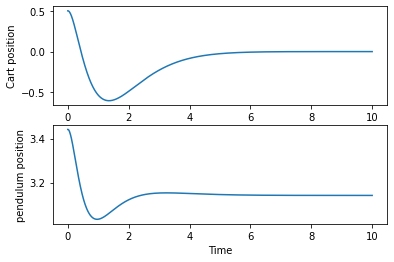

In [33]:
controller = LQRController(K, k, z_bar.flatten())
z0 = np.array([0.5,np.pi+0.3,0.,0])

z,u = cart.simulate(z0, controller, horizon_length)
t = np.linspace(0,cart.dt*(horizon_length),horizon_length+1)
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,z[0,:])
plt.ylabel('Cart position')
plt.subplot(2,1,2)
plt.plot(t,z[1,:])
plt.ylabel('pendulum position')
plt.xlabel('Time')


animate_cart_pole(z, cart.dt)

In [34]:
def timeEvolution(z, u, t):
  """
  Plot the time evolution of the system and control inputs.

  Args:
    z: the time evolution of the system;
    u: the time evolution of the control inputs.
    t: the time stpes.
  """

  plt.figure(figsize=(12, 10))

  plt.subplot(3, 2, 1)
  plt.plot(t,z[0,:])
  plt.ylabel('Cart Position')

  plt.subplot(3, 2, 2)
  plt.plot(t,z[1,:])
  plt.ylabel('Pendulum Angule')

  plt.subplot(3, 2, 3)
  plt.plot(t,z[2,:])
  plt.ylabel('Cart Velocity')

  plt.subplot(3, 2, 4)
  plt.plot(t,z[3,:])
  plt.ylabel('Pendulum Angular Velocity')
  plt.xlabel("Time")

  plt.subplot(3, 2, 5)
  plt.plot(t[:-1], u.flatten())
  plt.ylabel('Control Inputs')
  plt.xlabel("Time")

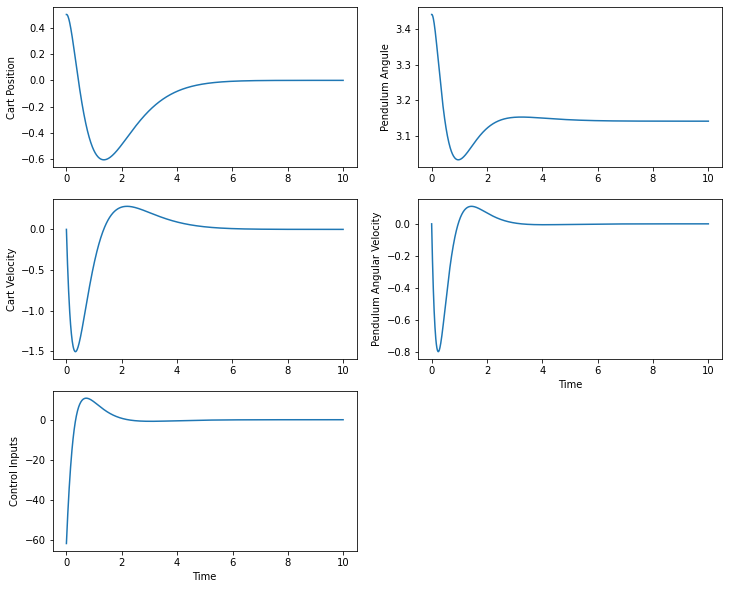

In [35]:
timeEvolution(z, u, t)

### 4) Another $z_0$

/home/pengbo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in double_scalars
/home/pengbo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in double_scalars
/home/pengbo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in matmul
  after removing the cwd from sys.path.
/home/pengbo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sin
/home/pengbo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in cos
/home/pengbo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in cos
/home/pengbo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sin


<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAAYOW1kYXQAAAKgBgX//5zcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENv
cHlsZWZ0IDIwMDMtMjAxNyAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9w
dGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1o
ZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2
IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0
X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTUgbG9va2FoZWFkX3RocmVhZHM9
MSBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxhY2VkPTAgYmx1cmF5X2Nv
bXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHlyYW1pZD0yIGJfYWRhcHQ9
MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3ZWlnaHRwPTIga2V5aW50
PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJlc2g9MCByY19sb29rYWhl
YWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAgcXBtaW49MCBxcG1heD02
OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAALtGWIhAAQ//73gb8yy18iuslx
+ed9LKzPPOQ8cl2JrrjQAAADAAADAACNeCrj1/4iY//ABRdFcWr6etCGysb0MU0N6mF1T5yfrSTY
urDQAKP9HRSb5Z6g6bB5S8Wm2m4pd3zObk0pQq2+a4k0J3V2yLs2jdFIPr88yn4nUjlKUkrtLyPk
N5eXXiZWS9ywOh6+3dA5JA9IXPueqGiM5ZiLOXr/dtpclq7bEspmkaOU1PddUhRC32YWjr39I31p
k/7Vtga8yRuy4BUkZqxMccacfraVvNX8XQJK0tAGEf9pznrbSXsh65R/rsd/GS0uPRNPRJUCH45l
faAgDsWRIjny819wNHUZdn/xhnpH5X9Uxs0D4qdSj7AnDvyDZE4eo7kg9TJpQfxc5/i/rbSTgV9W
qWjwKlskv6P6V0wMtwpUcQfmRlExqPh3Xu1s50ZcQE18eP3YnGGOKb8CCGTRjqpgwaAFUp/jL3bx
g6il0D+NeP7tt3+2AMsyLAojKr4tPC4iVtX6vhrb///vc6fX7kBFu0PgGnplU+TF/ZY0g9k3E0d/
qp74zliFJMqhoF+vlIitY/2rzi/+fT9w2dDn+f4eCFUOgIhBaGND+PGMXTOx8pcdAbJ77uLAY7zt
p5fqDzKrZ5j0qXIP7ew4deHyCYOWaf5oeNKrWI8u5xSw+QTByzT5wMtpoVa4I37qbEOEEwcs07ju
RAWjDPm1Taxh8KODabecJX/J++Flo3zEycOGkctsRjIOQXMgsa93EdmaRu7qIZAeNN2AnAHAb9nj
wZTa4tD+gFeqcaFu6m3367nWu+nf76VXmj9wVfGm07KrDpFb+5DFGDSTjDENJz+1kMu9EhgsaA8w
tAsPxfV4wwfa/Z7VB4vodtBvBoxNSbLvc2FJI6dgmSvJxPxTnX4n93jJ/OpzrPLCb9K4tlmvPScK
iUsh4oOYkqa62YUtmckuKzPy/KQwbA0JOjx5TgWWlm2yJUvDHeitIvW8VERDY3H//+5/8V14qcik
BlVLQ/fQ4lI59kZP4kLTU8yQjJsw1zhRQZ7NUex2dFnIzNv244Hoqmk9hYqGflKNhSNXE/r+PAfb
4L9o1Ty3s3TpxxCpAhb76m3ElC/N0TNfLswZeRfdDvBRqQdNKNwK25iLZ+ytkAy72GzLKHrfPilU
ss7AY6CuFm91aq4/TzZR3LL9iqIQc9ihzTPG0vm4AAYh4CeHjokn1TYFX/Rn/lYSi3jGMY2kdX6J
0nywaAmg9vfrlVIMqPhx6P/Z3K5Rais0wTHtRq9XXd4BWOp8OzsyciuKZLYbiU5SkR8OWko3z3dt
DqbcVt/tG3Vst0vDXyPzvbIg0o9mdEc7W+sbG3MGX4IZzM1+G4ZOGS/t+nPOXuHMDeHG/Eov7Rnm
+ihkxKEoV4dcItDasZ53MsBg7JU8rmBWcoPJC7CUsBp6rttjOvCor3PGYU3fVcPyeOasATgHfL/B
GUEIgun8Jl0AUJttZPPNKwLXpcfjfm2qrD/fFDAGqrCkO0v3ylLfvsJNQvHJ9Y8KBFOSfolltiY4
pRVQ3m3E5hDg3Tebq6dp7QIPbeTWTVsEvx7+T3WFzwhWnwC0w0S/FElWLW/VnZDIXCrK/4zLmVtA
9P9WdkMhEXJbpEIDjT6q/Eaj9OFszE3iE1J/TMxZ7asLBnrTfJsXJvnTc95aUF8HcB06gIgnSert
RGUBy6IjV0lNtaPpr2uwpxOF//XbJnPZ8Z2BP1ysZCI/5P/fBllnOtiK7hvPOjLxv9Xk+Vl1r3m+
t5MozOdVnnu926GCxmN398yFHc3ynG56vtyMAGwmpp/MlBhIAMzap5qDs9tzar7nwASYlt6TwLcB
Aj8k9NDB5utb2kihalIeuKezJ8Fj2fyiHOKf4PpnA7uwH5a5V9w74jdqv07zkwMmiIDUGvFJlRLX
5+ne+t+tBz/4S3NvJsUh1BO0XyJyYpI/ebqu7R/cRaLs2rlp9n+awnej0PLz+8TtXVrAvxuPNsNH
bMU9Lo6FJKCE9adB51fjGhuyMSJrRFtO3Dc02nldG+mo+KU4dOyKAP2ltlxYsUuAMKskNxFJo9GW
cIB3ARYeAt+PhgrDfrZVYS8MuO9yuIN9B00R+7xbw56349YZE4Af6UHhkMLmnqVd1uYGxD0Fbkw+
7LAEsL92kJ4JZYRT8cv0a1cROAH7RIwVR66xRJjXHqWbfy12N6UCPflFOWuAVZEHqTLD/REN27/v
g8ntWTP7NiBBkb2WUnJsK2/nWh0H56qMJf4XtP07y1A82kZ9/2/jlWDKjrIB9RtcZq3A5tptDwUj
zFzVEeH2qipumN9cov3bdv08TH5G26l7QB4/h8coIWXS6gmcAEO/7EonI4pK46kr3R2qUFuwl4wL
Z3mUeCrCucN8cce4O5QvtqTNuuJGtttj/cKGhIhMFrR1XjDPAASQCk9+VXewdz2gPUZgnrjNOlVc
AwArQnMFQyWY/Va4CeIpOxW4cOojAAlEDkKOzQ5AC6Mi9dwFal021/6MwnksXAr7uoB4JAHsH5za
J5BWdgbE4joPc/gbVcbsmC6VdP+pUeD9nIall1WDvhCcFu7H7Txm+pa6HwSZxwuogQYRJQI/InKk
brUBAHKWUI4cwBMRjY2sptkyMAmKesy5KBG6JaPPKyJ6yUPUrr0VR1LuMvGkuHIHaqlGrM34evYm
JXPEVZwAyPRzI14nxouHlhyOs5auUqPVrsPAhl/AHn5MuCI3Rw3PJOAEr3fgXrPoVd2AmZmHVjCT
zlFbDPzJTn/kOU7aWFmPPH18EgCjfyOyIjTCg4v+DRrczZ1TPE7pv+oRxy3xhzxaOORKSUH5zD8t
uhZgSRpakevlJf9An5TZ1T9eR9Ed/EXM5nFS3M2dUzxO6b4P/yuDKEPQ+FbIpUXNVdSrSMArpH5j
dYD8Wk9G29l3S0jTEtk4M

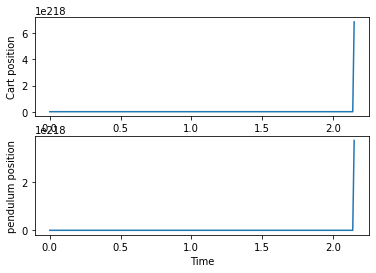

In [36]:
controller = LQRController(K, k, z_bar.flatten())
z0 = np.array([0.5,0.3,0.,0])

z,u = cart.simulate(z0, controller, horizon_length)
t = np.linspace(0,cart.dt*(horizon_length),horizon_length+1)
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,z[0,:])
plt.ylabel('Cart position')
plt.subplot(2,1,2)
plt.plot(t,z[1,:])
plt.ylabel('pendulum position')
plt.xlabel('Time')


animate_cart_pole(z, cart.dt)

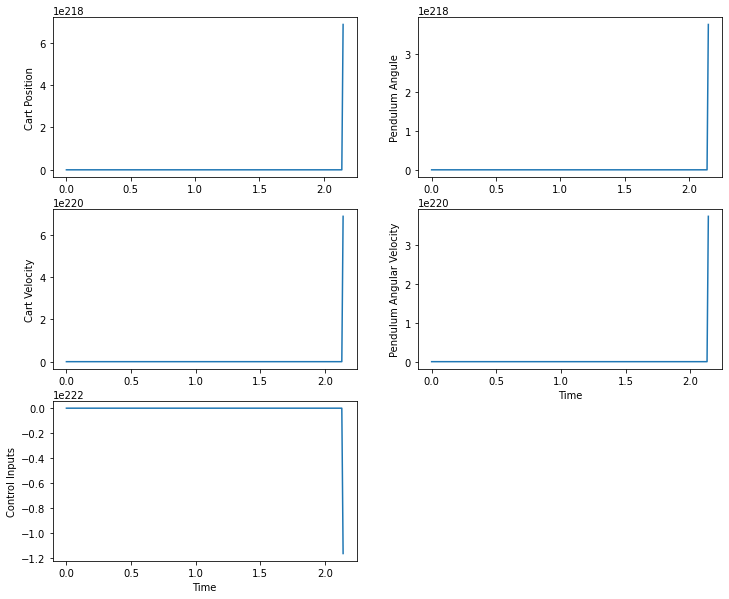

In [37]:
timeEvolution(z, u, t)

## Question 2

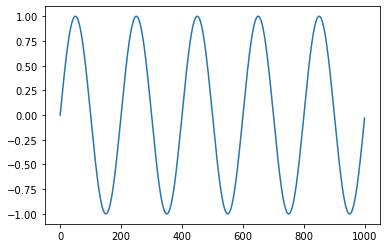

In [38]:
f = 0.5
dt = cart.dt

xs = np.sin(2*np.pi*f*np.arange(N)*dt)
plt.plot(xs)

### 1) Cost Function

In [39]:
Q = np.eye(4)
R = 0.01*np.eye(1)

N = 1000

xs = np.sin(2*np.pi*f*np.arange(N)*dt)
vs = 2*np.pi*f*np.cos(2*np.pi*f*np.arange(N)*dt)
Xs = [np.array([[xs[i]], [np.pi], [vs[i]], [0.0]]) for i in range(N)]

### 2) Controller

In [40]:
Ks, ks = LQRTracking(A, B, Q, R, N, Xs)

K = Ks[0]
k = ks[0]

print(K)
print(k)

[[   9.53146 -220.97185   20.19384  -67.99139]]
[[10.88509]]


In [41]:
def LQRTrackingController(Ks, ks, zs):

  def controller(z, i):
    u = Ks[i] @ (z-zs[i]) + ks[i]
    return u
  
  return controller

### 3) Time Evolution

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABb7m1kYXQAAAKgBgX//5zcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENv
cHlsZWZ0IDIwMDMtMjAxNyAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9w
dGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1o
ZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2
IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0
X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTUgbG9va2FoZWFkX3RocmVhZHM9
MSBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxhY2VkPTAgYmx1cmF5X2Nv
bXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHlyYW1pZD0yIGJfYWRhcHQ9
MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3ZWlnaHRwPTIga2V5aW50
PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJlc2g9MCByY19sb29rYWhl
YWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAgcXBtaW49MCBxcG1heD02
OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAALr2WIhAAQ//73gb8yy18iuslx
+ed9LKzPPOQ8cl2JrrjQAAADAAADAACNeCrj1/4iY//ABRdFcWr6etCGysb0MU0N6mF1T5yfrSTY
urDQAKP9HQ9av0edyWUtNxS7vmc3Jp850RpSau2Rdm0bopB+o6hOFvebShtXaLptPpjVPBtwnJmy
cSWrwVkUZcs37PN8OA7Ch7YKgRSfRpWS03mvcnqg5Ad6jKXX9DDvMjWtLP87meMCmCubSh2FNtww
1JoHib7hlsGep1Q0IT7u3vF9x7yXmsmjwcgQKyqXQJK1KoYRkEGvhERJfvGGvfD1ykAlQ5qxNn8I
OdHI1eRUMcDIC9AimxR9bueFq8zhUkop3xKw5nX5pSW1s0D4qdSdrsG90s39Pq01QHKxcuqyKErn
P8X9baScCXa1hUZicjIg8KT2zgc6qc9+XOEPYY4it/5QqT9UshAzicibl5eWpktsa/CIKNcMi6nr
NHcHqaVIBBFUrtILNnmkUUcKiSry37oaSXNGhWNXyJvjIjiKqjn///wcvcF4ICLdofANPTKd9tGg
ywaQbh61XD6LHsl/gNaemU4vkfvywF1FEvy+PllFWPk1s6HP8/X7BTIF1Py7U+PhEWTjvjyWgUEF
d5jSUHPC4AW3UBdqNZbwtLSkweuFix9bCIXSevlqvpjob+lCNx56tOUxnbKGz3XVXG1R2ppZhmPR
jiK5BeTBpFWVYnr/E/k0psgZo7o4u4f+jeMwVusXfIQbZp5kab0dLOoREj5u+8IMwFHdJ/womEqf
pKbbXs982DFfh8ZIloVvQgP48LZxbHUP+XlObngUoNAEuZpPhOuy2SHUGHQmWqmsvyAdDorsO4FO
uSlYlwAz0eo4YQsmFbvBXiUrXaQRGF34BE2FX/HPvIXtb4TgRiZO3tjRBKp7lFnnuqLyjQK2tHSa
2JTYGahl8dSlcT8yoCRg2zh4B6mgIJ3rVP91bubju/FLiMEH2HuOlkvoRSsoAjZXsDf41lZUN7zM
gjv2vpy+OF/mVqkf8z1LvCyZzzQJaC6rsxnmPL3zBtOd/Uwfl1AM7DU+671cguBhXyu91sGB4m/V
lgCktUyE29Qk5d9rKVTZZZE3OM3gPYTjXM3kw1qYYS2tQMzQdg/1Xeqpv9XK53tVt19LFIh8N4at
8MVyRWVl2/TyVK88FxieuZmFekulKKG4xSgGox5NlQvOJN6dYCPcS+mZRHnJYiyXWfaoTkPneqvq
nzILO1Z/JfZa00kQh3gwy1x0wJwurv85wohiLzlahr2hU/pSU9rJJsfmzpKivND9IvtaKAuqYOE4
fWAuFYjgyUFZ/7v3YmAWccFFyjefVtcRHRNO7/1dH7QfuiPQNZNpCkmGg6bFdM+/xcvkdO/RD5x/
FYceIEcdSfts3mIkUWEQbss1yZrRHyGBSn40uPUwAD8sr0vznYi3IK8nWNMv++JuvFpd/2mrM2g+
b/MRrj2Amao7MjYnbBj10vY1poBauRrxX+4F75LKYF/ULp1Mr87NqvfJUR9fPRU8A7OrxHQwn5Pu
k1WIHONi38Bpr/aztsqKWFfZtUpe7Gn//FoKwANLqwL5mcXjmIceCiIfWtqbBgx7uv5Z+z1UguCn
vuR/V9QokgG0F2o/wv8C6FkPeqGLUwFin8+OYXpASWhExIwaWkSjFf55zjgWxCbAtMLmHZ5CrqVi
GwMlNZuPhdyZWltrzf8Na6wYS/1XvU5+UpJ0wE8cH+W7p1M6NFB1NblO7WFkE0pZiq2xkcHrqpku
4ynagMgMywlvMoAB5H7/nhYdMXpZkRc1L9RZRWtv+Yrs70kkGJ/HztJg4LJUPDdJy8ljPWlhlhsW
th/pMno0t1qtA3j7a4tiyoHPqwRmIFHAHe9Qi8Nt6eRhsty5IOkaXnLMC/5kmTTpxKbJGaSzK55R
OG6IsqkoPbSlCRXZcSdAOluX4ip318PlPi0MZZEVt2kzAADMLdXawusU7uXWqlXrFheotuJ85qKg
DoXSXRq0QkWZ+Jzc5z8Trc8jvZi80K1xczoXxVhK+J8ZRc/9BVS7b2wfxZ0sery1xC4sC/I847qa
aFOptaMD04AYr7GHd8B/R/BG3k2ZMDXV1kijMn6DsWbVZb2+sAkZTRV2L21XWdKCdMZLvYrt0lUU
9Lo6FJKCcTXXDBVratQ69f9IOhLtXF8TBgP84FT+z8YPs07IoA+ljLv7fsO/bDnUAfqwX39+Mq46
EVurnAYIGbLrC6KvrgLI4Lw/ISrflVhhElVQNhzyyF4BEs8Kta4/qHAKKNH19I+HIGXgCsDBYlMj
iC5I+PUh0lhVXpY/e4nt/dyIP3u0NatxXdQBtIpvPPBPDsH1v8pzPaSSbXvesipRgbX++gWkzXZU
aGfxSL+pePCsDdiQn9VGxW2k1D2Tp3pgOxyygmLnvyjF6S3n5UaGfNaJ0lb24NbPMrVj/fKybpXp
93rxJjmAuCOyFPlzCvFNF5ATIR4b7CAALGp3Uy6sePGPrXxZqVBNmJIOwHzoN4kQKtrr2+lyjOmx
7AYFf2gDCZSZvkNaRqWRfd4Y688iopgYr/mruA6wSaq0yw42X4TJsaPCheMV6MV7XbK/iL3TRqsk
RKciCRzVeOSacyO33IGiFvW/b8hfbG/IU8QgjA9G2B52fIPiQ5RX9e1a+wzmshz0UY1E2im2kSW4
y8aS2gaH7lYRbzfh69jNc7Q1dnoKZwQMEOjyJ0S0bXwuUN4lJB2nX8XF0p+r5o5MuEcDxpueScAJ
Xu/Auy32SFumP6T9qf7YRRwxCxWHZPuhzopr+HD0y1qpv//jVv6rKgBOoThqHJafOISC4lDyOTjs
jPFo45Enik+CpW2lfihozl9rxcMoRX3x61oJMHd8tPIuSXP1rHIvioep1WnR08MZrHZdtq2I+VPL
dntd4548QT03r4uM7QKtF

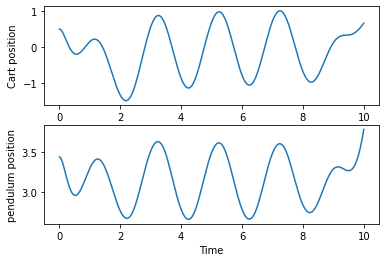

In [42]:
controller = LQRTrackingController(Ks, ks, [x.flatten() for x in Xs])
z0 = np.array([0.5,np.pi+0.3,0.,0])

z,u = cart.simulate(z0, controller, horizon_length)
t = np.linspace(0,cart.dt*(horizon_length),horizon_length+1)
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,z[0,:])
plt.ylabel('Cart position')
plt.subplot(2,1,2)
plt.plot(t,z[1,:])
plt.ylabel('pendulum position')
plt.xlabel('Time')

animate_cart_pole(z, cart.dt)

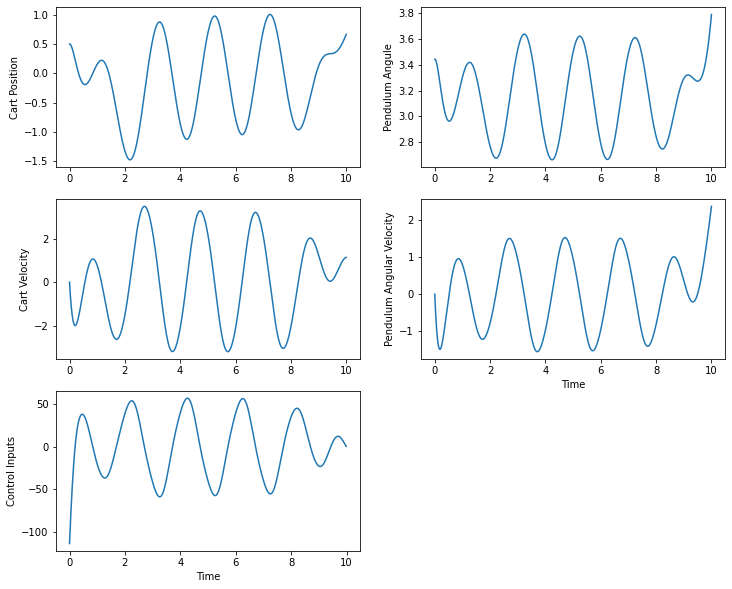

In [43]:
timeEvolution(z, u, t)

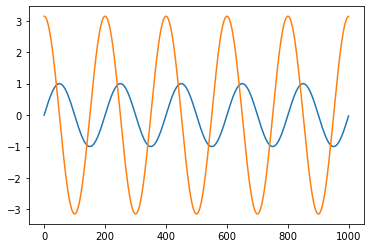

In [44]:
plt.plot([x[0] for x in Xs])
plt.plot([x[2] for x in Xs])

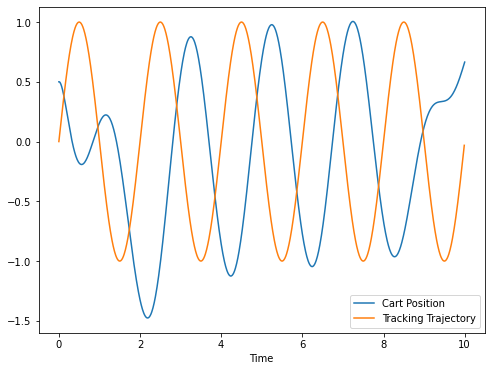

In [45]:
plt.figure(figsize=(8,6))
plt.plot(t, z[0], label="Cart Position")
plt.plot(t[:-1], [x[0] for x in Xs[:1000]], label="Tracking Trajectory")
plt.xlabel("Time")
plt.legend()

In [46]:
Q = np.eye(4)
R = 0.01*np.eye(1)

N = 1100

xs = np.sin(2*np.pi*f*np.arange(N)*dt)
vs = 2*np.pi*f*np.cos(2*np.pi*f*np.arange(N)*dt)
Xs = [np.array([[xs[i]], [np.pi], [vs[i]], [0.0]]) for i in range(N)]

Ks, ks = LQRTracking(A, B, Q, R, N, Xs)

In [47]:
K = Ks[0]
k = ks[0]

print(K)
print(k)

[[   9.53146 -220.97185   20.19384  -67.99139]]
[[10.8853]]


<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABdRW1kYXQAAAKgBgX//5zcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENv
cHlsZWZ0IDIwMDMtMjAxNyAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9w
dGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1o
ZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2
IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0
X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTUgbG9va2FoZWFkX3RocmVhZHM9
MSBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxhY2VkPTAgYmx1cmF5X2Nv
bXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHlyYW1pZD0yIGJfYWRhcHQ9
MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3ZWlnaHRwPTIga2V5aW50
PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJlc2g9MCByY19sb29rYWhl
YWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAgcXBtaW49MCBxcG1heD02
OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAALumWIhAAQ//73gb8yy18iuslx
+ed9LKzPPOQ8cl2JrrjQAAADAAADAACNeCrj1/4iY//ABRdFcWr6etCGysb0MU0N6mF1T5yfrSTY
urDQAKP9HQ9av0edyWUtNxS7vmc3Jp850RpSau2Rdm0bopB+o6hOFvebShtXaLptPpjVPBtwnJmy
cSWrwVkUZcs37PN8OA7Ch7YKgRSfRpWS03mvcnqg5Ad6jKXX9DDvMjWtLP87meMCmCubSh2FNtww
1JoHib7hlsGep1Q0IT7u3vF9x7yXmsmjwcgQKyqXQJK1KoYRkEGvhERJfvGGvfD1ykAlQ5qxNn8I
OdHI1eRUMcDIC9AimxR9bueFq8zhUkop3xKw5nX5pSW1s0D4qdSdrsG90s39Pq01QHKxcuqyKErn
P8X9baScCXa1hUZicjIg8KT2zgc6qc9+XOEPYY4it/5QqT9UshAzicibl5eWpktsa/CIKNcMi6nr
NHcHqaVIBBFUrtILNnmkUUcKiSry37oaSXNGhWNXyJvjIjiKqjn///wcvcF4ICLdofANPTKd9tGg
ywaQbh61XD6LHsl/gNaemU4vkfvywF1FEvy+PllFWPk1s6HP8/X7BTIF1Py7U+PhEWTjvjyWgUEF
d5jSUHPC4AW3UBdqNZbwtLSkweuFix9bCIXSevlqvpjob+lCNx56tOUxnbKGz3XVXG1R2ppZhmPR
jiK5BeTBpFWVYnr/E/k0psgZo7o4u4f+jeMwVusXfIQbZp5kab0dLOoREj5u+8IMwFHdJ/womEqf
pKbbXs982DFfh8ZIloVvQgP48LZxbHUP+XlObngUoNAEuZpPhOuy2SHUGHQmWqmsvyAdDorsO4FO
uSlYlwAz0eo4YQsmFbvBXiUrXaQRGF34BE2FX/HPvIXtb4TgRiZO3tjRBKp7lFnnuqLyjQK2tHSa
2JTYGahl8dSlcT8yoCRg2zh4B6mgIJ3rVP91bubju/FLiMEH2HuOlkvoRSsoAjZXsDf41lZUN7zM
gjv2vpy+OF/mVqkf8z1LvCyZzzQJaC6rsxnmPL3zBtOd/Uwfl1AM7DU+671cguBhXyu91sGB4m/V
lgCktUyE29Qk5d9rKVTZZZE3OM3gPYTjXM3kw1qYYS2tQMzQdg/1Xeqpv9XK53tVt19LFIh8N4at
8MVyRWVl2/TyVK88FxieuZmFekulKKG4xSgGox5NlQvOJN6dR1bQJMpqAtwhzWuXfn9X9AypKJ8L
Gj6/shHSnzxoqqo56hEq8fLnd/lTd96WVE0EhVYWhUl582xHbX5M6G6UCMSJ+8X9QeKxIohjUqlP
nKI/AaUf/IGYQRYU15pco3n1bXER0ZlZv/DtTe4cHeaU8k2kKSYaDpves+Ymi4zqKd+iHzj+Kw9M
Nh+7dFumjcknrFXQOyfH35qqwfHClPxpcepgAGrrkryTEjC30SbFKnkMMnW5Rx/7FYt0HaD5v8xG
uPYCZqjgyNidsGPXS9jWmgDQiN+qPNspxKffy3Kw/AMRzIDar3yVEfXxiLYvLopznRg3us1OrxWm
wyVPuk1WIHONCH6kwcAjonJqYyHXIvFDmh3x/+6e2loVaRIDtfIcd0jVozqdVE0Ix9rHk7fl/7PV
QK4IcCmOQrxFEkA2orFX7RUgbPjA6XOYZ1VLUh90GF6QEloRUf6m4YDdLRhJ+HpKDTCljAPy9t7r
VciK8QLSpOtkgu5MrS215v+GtdZBVf6r/c8l4wm5yWZcgEZF8amdGig6mtyndrCzZ8MG1QjeZh3L
QhP7KBvwsAAmZbVX4Q7RQFo/7RcrB6hhn+lzUv1FlFa2/5TQ2GrZY569HztJQvygHDFlX4snv1DI
OzQUmSN8+7eAnL7DcT5olTU+PLxS/4AS+a7u4DW36L+VMGvi72ZY9CBFLOPN4Y83wffHC7KM6CJZ
RW9wP6Cq++Sg9tT+f9AMecC+i4nc5/fxFTvrO7DYeqP3Wa3rRxNIAJld+YIIW6JUxutVKvWLC9Rb
cQ5zUVAHQvdc719qIBnETm5zn4ogeoOFJFS0K3rzmQdDSk9D1e1Zbs0dkf5EcD3nFv48D2kyBOLA
vyPOO6mmhTptkPk+D2rVW2/e/4QiP4I28mzJga6uQq89fxeMy+czyTzKzCd2lChYvbVdZ0qtkxky
+ePbpKop6XR0KST2NsuuGCrW1ah16/6QU0lNCfzovJC51qUNqRGF0sKpQB9LGX3HJBdNXgjQU/Vg
vTy6MrK+WzqxwGFhv+gQ37WVAflDN45fruoMfq9wCc9ktwCTC44BLPCuaD1ywq2Hi6kZCkhyBl4A
rAwTmYvtf/yfnWm70sfvcT2/u5EH8qmOx6LCf84QWfOrJzNl7WPTUTZWYoboF2LdTbkAC1qsJ1ix
EsD1WvGEeG772kWAF5qfcFQQb2q1vuy5taSSxsj5ak7bheMxhfo6YrUMdtuysPhzMupErCBipnC9
UT069oRg5ESV6fJ56MLzb5WmDL3u8AApqZjDY+VJ868nqXYENvBtcASMHahOYL8NSv7ZKu6vl07g
MCv7QPKazM3yGtI1LIvu8MdhRX/hAMV/zV3AZGJNECZYcblQgTR4ZEINvikxxfh4xr8eZ4aNVkiJ
VUdWJEDkOfWRTZFe5V9ml4iMuGDVbxcocbwmpgxzDGATI9W6dM5rqyio88rInrJQ9SuYaHRQqbjL
xpNPJjmZ0hFvN+Hr2No+eLQ8wAyPRzI14CO2sHlhyOs5auUpu6c3tSC4n5oLlqAYQwPGm55JwAle
78C88HpIW6Y/pP2p/thFHDELJ2Xmrmw3oC+f0b9Mye4nhy8//xq3rvqjDIjiqQ6o+Lj4uR4x8h//
wwM2TmuaHOXRFOJbSTz/raKnmo/FMHIs3W+dPfzpvdst+zYhjtPvH3dIZo1Z1vx7PmqITxDKVcDx
L8qj9ip4JdOM9bNvYjxso

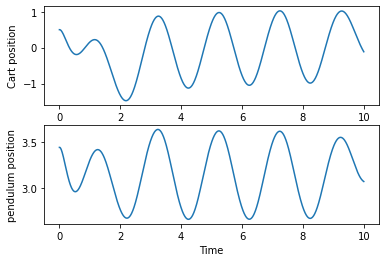

In [48]:
controller = LQRTrackingController(Ks, ks, [x.flatten() for x in Xs])
z0 = np.array([0.5,np.pi+0.3,0.,0])

z,u = cart.simulate(z0, controller, horizon_length)
t = np.linspace(0,cart.dt*(horizon_length),horizon_length+1)
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,z[0,:])
plt.ylabel('Cart position')
plt.subplot(2,1,2)
plt.plot(t,z[1,:])
plt.ylabel('pendulum position')
plt.xlabel('Time')

animate_cart_pole(z, cart.dt)

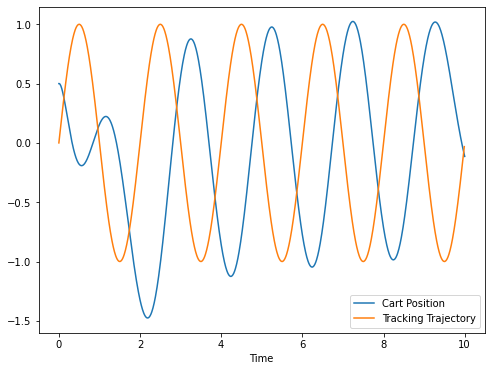

In [49]:
plt.figure(figsize=(8,6))
plt.plot(t, z[0], label="Cart Position")
plt.plot(t[:-1], [x[0] for x in Xs[:1000]], label="Tracking Trajectory")
plt.xlabel("Time")
plt.legend()

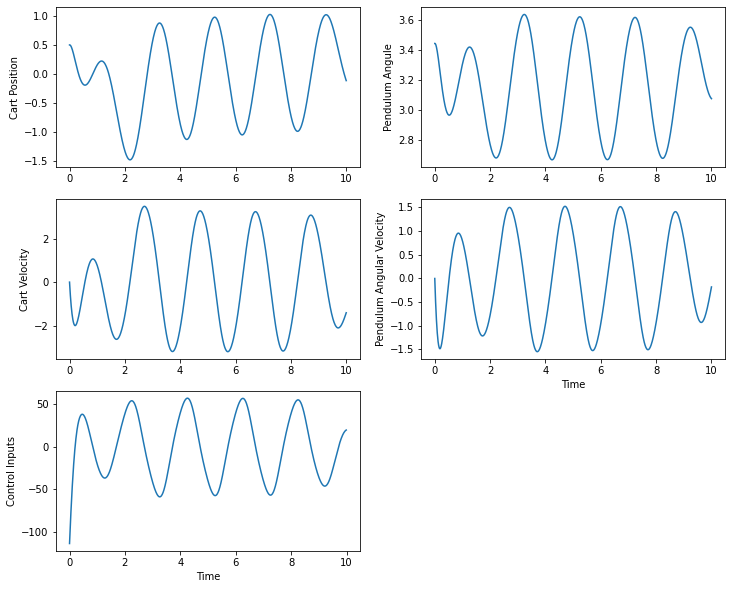

In [50]:
timeEvolution(z, u, t)

### 4) Cost Values

In [51]:
N = 1000

Xs = [np.array([xs[i], np.pi, vs[i], 0.0]) for i in range(N+1)]
Xs = np.array(Xs)

In [52]:
def LQRTracking(A, B, Q, R, N, Xs):
  """
  Solve the LQR tracking problem with given system and cost function.

  Args:
    A: the system dynamics;
    B: the control matrix;
    Q: the quadratic cost matrix, x.T Q x;
    R: the quadratic cost matrix, u.T R u;
    N: the number of time step;
    Xs: the tracking target.
  
  Return:
    Ks: the linear feedback gains.
    ks: the feed-forward gains.
  """

  def DARE(P, p, q):
    """
    A helper function to solve discrete-time algebraic Riccati equation (DARE) 
    for tracking problem for each time step.
    """

    K = -np.linalg.inv(B.T @ P @ B + R) @ B.T @ P @ A
    P = Q + A.T @ P @ A + A.T @ P @ B @ K

    k = -np.linalg.inv(B.T @ P @ B + R) @ B.T @ p
    p = q + A.T @ p  + A.T @ P @ B @ k

    return K, P, k, p

  Ks = []
  ks = []
  Ps = []
  ps = []

  P = Q
  p = -Q @ Xs[-1]
  Ps = [P]
  ps = [p]

  for t in range(N-1, -1, -1):
    q = -Q @ Xs[t]
    K, P, k, p = DARE(P, p, q)

    Ks = [K] + Ks
    ks = [k] + ks
    Ps = [P] + Ps
    ps = [p] + ps
  
  return Ks, ks, Ps, ps

In [53]:
Ks, ks, Ps, ps = LQRTracking(A, B, Q, R, N, Xs)

In [54]:
Ks[0]

array([[   9.53146, -220.97185,   20.19384,  -67.99139]])

In [55]:
z = z.T
len(z)

1001

In [56]:
Jp = []
for i in range(N):
  P = Ps[i]
  p = ps[i]

  xr = z[i]
  xt = Xs[i]
  ut = u[:, i]
  dx = xr - xt

  jp = dx.T @ P @ dx + 2*p.T @ dx
  Jp.append(jp.flatten())

i += 1
P = Ps[i]
p = ps[i]

xr = z[i]
xt = Xs[i]
dx = xr - xt

jp = dx.T @ P @ dx
Jp.append(jp.flatten())

Jp = np.array(Jp)

In [57]:
Jr = []

for i in range(N):
  xr = z[i]
  xt = Xs[i]
  ut = u[:, i]
  dx = xr - xt

  j = dx.T @ Q @ dx + ut @ R @ ut
  j = j.flatten()
  Jr.append(j)

i += 1
xr = z[i]
xt = Xs[i]
# dx = xr - xt

j = dx.T @ Q @ dx
j = j.flatten()
Jr.append(j)

Jr = np.array(Jr)

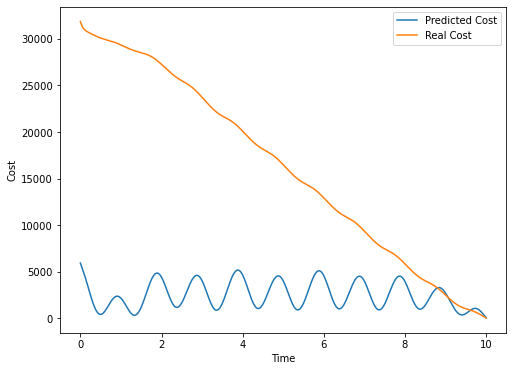

In [58]:
plt.figure(figsize=(8,6))
plt.plot(t, Jp, label="Predicted Cost")
plt.plot(t, Jr[::-1].cumsum()[::-1], label="Real Cost")
plt.xlabel("Time")
plt.ylabel("Cost")
plt.legend(loc="upper right")